In [2]:
import pandas as pd
import numpy as np
import polars as pl


In [40]:
df = pd.read_csv('data/nyc_taxi_2019-01.csv', 
                 usecols=['passenger_count', 'trip_distance', 'total_amount'])

In [3]:
df = pl.read_csv('data/nyc_taxi_2019-01.csv', 
                 columns=['passenger_count', 'trip_distance', 'total_amount'])

In [41]:
%%timeit
# the average cost of the 20 longest (in distance) taxirides in January 2019 (descending)
(
    df
    .sort_values(by=["trip_distance"], ascending=False)[:20]["total_amount"]
    .mean()
)

748 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
(
    df
    .sort(by=["trip_distance"], descending=True)[:20]
    .select(pl.col("total_amount"))
    .mean()
)

178 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%%timeit
# the average cost of the 20 longest (in distance) taxirides in January 2019 (ascending)
(
    df
    .sort_values(by=["trip_distance"])[-20:]["total_amount"]
    .mean()
)

719 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
(
    df
    .sort(by=["trip_distance"], descending=False)[-20:]
    .select(pl.col("total_amount"))
    .mean()
)

173 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%%timeit
# Sort by ascending passenger count and descending trip distance
# Average price paid for the top 50 rides

(
    df
    .sort_values(
        by=["passenger_count", "trip_distance"], 
        ascending=[True, False])[:50]["total_amount"]
    .mean()
)

344 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
(
    df
    .sort(by=["passenger_count", "trip_distance"], descending=[False, True])[:50]
    .select(pl.col("total_amount"))
    .mean()
)

257 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
# In which five rides did people pay the most per mile? 
# How far did people go on those trips?
(
    df
    .replace(0, np.nan)
    .dropna()
    .assign(cost_per_mile=df["total_amount"]/df["trip_distance"])
    .sort_values(by="cost_per_mile", ascending=False)[:5]
    [["trip_distance", "cost_per_mile"]]
)

1.17 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
(
    df.filter((pl.col("total_amount") != 0) & (pl.col("trip_distance") != 0))
    .with_columns(
        (pl.col("total_amount")/pl.col("trip_distance")).alias("cost_per_mile"))
    .sort(by="cost_per_mile", descending=True)[:5]
    .select("trip_distance", "cost_per_mile")
)

197 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
# Assume that multipassenger rides are split evenly among the passengers.
# In which 10 multipassenger rides did each individual pay the greatest amount?

(
    df[(df['total_amount'] != 0) & (df['passenger_count'] != 0)]
    .assign(cost_per_passenger=df["total_amount"]/df["passenger_count"])
    .sort_values(by="cost_per_passenger", ascending=False)[:10]
)

1.01 s ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
(
    df.filter((pl.col("total_amount") != 0) & (pl.col("passenger_count") != 0))
    .with_columns(
        (pl.col("total_amount")/pl.col("passenger_count")).alias("cost_per_passenger"))
    .sort(by="cost_per_passenger", descending=True)[:10]
)

182 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
df=None

In [1]:
import pyarrow as pa
import pyarrow.csv
import pyarrow.compute as pc

In [2]:
co = pa.csv.ConvertOptions(include_columns=['passenger_count', 'trip_distance', 'total_amount'])
df = pa.csv.read_csv('data/nyc_taxi_2019-01.csv', convert_options=co)


In [ ]:
%%timeit
pa.compute.mean(
    pa.compute.take(
    df,
    pa.compute.sort_indices(df, sort_keys=[("trip_distance", "descending")])
    )["total_amount"][:20]
)

1.14 s ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Part 2

In [8]:
df = pd.read_csv('data/nyc_taxi_2019-01.csv', 
                 usecols=['passenger_count', 'trip_distance', 'total_amount'])

In [25]:
df = pl.read_csv('data/nyc_taxi_2019-01.csv', 
                 columns=['passenger_count', 'trip_distance', 'total_amount'])

In [2]:
co = pa.csv.ConvertOptions(include_columns=['passenger_count', 'trip_distance', 'total_amount'])
df = pa.csv.read_csv('data/nyc_taxi_2019-01.csv', convert_options=co)

In [22]:
%%timeit
# For each number of passengers, find the mean cost of a taxi ride. Sort this
# result from lowest (i.e., cheapest) to highest (i.e., most expensive)

(
    df.groupby("passenger_count")
    .agg(mean_cost=("total_amount", "mean"))
    .sort_values(by="mean_cost", ascending=True)
)

88.1 ms ± 153 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
(
    df.group_by(pl.col("passenger_count"))
    .agg(pl.col("total_amount").mean().alias("mean_cost"))
    .sort(by="mean_cost")
)

14.9 ms ± 631 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
s = pa.TableGroupBy(df, "passenger_count").aggregate([("total_amount", "mean")])
pc.take(
    s,
    pc.sort_indices(
        s, sort_keys=[("total_amount_mean", "descending")])
)


8.65 ms ± 371 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
# Sort again by increasing the number of passengers
(
    df.groupby("passenger_count")
    .agg(mean_cost=("total_amount", "mean"))
    .sort_values(by=["passenger_count"], ascending=True)
)

88.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
(
    df.group_by(pl.col("passenger_count"))
    .agg(pl.col("total_amount").mean().alias("mean_cost"))
    .sort(by="passenger_count")
)

14.4 ms ± 311 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%%timeit
(
    df.group_by("passenger_count")
    .aggregate([("total_amount", "mean")])
    .sort_by([("passenger_count", "descending")])
)

8.67 ms ± 386 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
# Create a new column, trip_distance_group in which the values are short (< 2
# miles), medium ( 2 miles and 10 miles), and long (> 10 miles). What is the
# average number of passengers per trip length category? Sort this result from
# highest (most passengers) to lowest (fewest passengers)

(
    df
    .assign(
        trip_distance_group = pd.cut(df['trip_distance'], 
        bins=[0, 2, 10, float("inf")], 
        labels=['short', 'medium', 'long'], 
        include_lowest=True))
    .groupby("trip_distance_group", observed=True)
    .agg(mean_pass=("passenger_count", "mean"))
    .sort_values(by="mean_pass", ascending=False)
 )
 

201 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
(
    df.with_columns(
        pl.col("trip_distance")
        .cut([2, 10], labels=["short", "medium", "long"])
        .alias("trip_distance_group"))
    .group_by(pl.col("trip_distance_group"))
    .agg(pl.col("passenger_count").mean().alias("mean_pass"))
    .sort(by="mean_pass")
)

294 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
a = pc.less_equal(df["trip_distance"], 2).combine_chunks()
b = pc.greater(df["trip_distance"], 10).combine_chunks()
arrs = pa.StructArray.from_arrays([a, b], ["1", "2"])
(
    df
    .append_column(
        pa.field("trip_distance_group", pa.string()), 
        pc.case_when(arrs, "short", "long", "medium"))
    .group_by("trip_distance_group")
    .aggregate([("passenger_count", "mean")])
    .sort_by([("passenger_count_mean", "descending")])
)

116 ms ± 443 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [181]:
%%timeit
# Create a single data frame containing rides from both January 2019 and Janu-
# ary 2020, with a column year indicating which year the ride comes from. Use
# groupby to compare the average cost of a taxi in January from each of these two
# years
import pandas as pd
files = ["data/nyc_taxi_2019-01.csv", "data/nyc_taxi_2020-01.csv"]
df_file_gen = (pd.read_csv(f, usecols=['tpep_pickup_datetime','passenger_count', 'trip_distance', 'total_amount']) for f in files)
df = pd.concat(df_file_gen, ignore_index=True)

6.64 s ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [185]:
%%timeit
import polars as pl
files = ["data/nyc_taxi_2019-01.csv", "data/nyc_taxi_2020-01.csv"]
df = pl.scan_csv('data/nyc_taxi_*.csv', try_parse_dates=True).select(['tpep_pickup_datetime', 'passenger_count', 'trip_distance', 'total_amount']).collect()

443 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [178]:
%%timeit
(
    df
    .assign(year=pd.DatetimeIndex(df['tpep_pickup_datetime']).year)
    .drop(columns=["tpep_pickup_datetime"])
    .groupby("year")
    .aggregate(mean=("total_amount", "mean"))
    .query("year == 2019 or year==2020")
)

3.67 s ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [183]:
%%timeit
(
    df
    .with_columns(pl.col("tpep_pickup_datetime").dt.year().alias("year"))
    .drop("tpep_pickup_datetime")
    .group_by(pl.col("year"))
    .agg(pl.col("total_amount").mean().alias("mean"))
    .filter((pl.col("year") == 2019) | (pl.col("year") == 2020))
)

46.3 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [180]:
%%timeit
# Create a two-level grouping, first by year and then by passenger_count
(
    df
    .assign(year=pd.DatetimeIndex(df['tpep_pickup_datetime']).year)
    .drop(columns=["tpep_pickup_datetime"])
    .groupby(["year", "passenger_count"])
    .aggregate(mean=("total_amount", "mean"))
    .query("year == 2019 or year==2020")
)

4.04 s ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [184]:
%%timeit
(
    df
    .with_columns(
        pl.coalesce(pl.col("passenger_count"), 0).alias("passenger_count"),
        pl.col("tpep_pickup_datetime").dt.year().alias("year"),
    )
    .drop("tpep_pickup_datetime")
    .group_by(["year", "passenger_count"])
    .agg(pl.col("total_amount").mean().alias("mean"))
    .filter((pl.col("year") == 2019) | (pl.col("year") == 2020))
    .sort(by=["year", "passenger_count"])
)

87.6 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [189]:
%%timeit
import pyarrow.csv
files = ["data/nyc_taxi_2019-01.csv", "data/nyc_taxi_2020-01.csv"]
opts = pyarrow.csv.ConvertOptions(
    include_columns=['tpep_pickup_datetime', 
                     'passenger_count', 'trip_distance', 'total_amount'])
tables = (pyarrow.csv.read_csv(f, convert_options=opts) for f in files)
df = pa.concat_tables(tables)

400 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [187]:
%%timeit
import pyarrow.compute as pc
(
    df
    .append_column(
        pa.field("year", pa.int64()), pc.year(df["tpep_pickup_datetime"])
    )
    .append_column(
        pa.field("passenger_count_", pa.int64()), 
        pc.coalesce(df["passenger_count"], 0)
    )
    .drop_columns(["passenger_count", "tpep_pickup_datetime"])
    .group_by("year")
    .aggregate([("total_amount", "mean", pc.CountOptions(mode="only_valid"))])
    .filter((pc.field("year") == 2019) | (pc.field("year") == 2020))
)

115 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
%%timeit
(
    df
    .append_column(
        pa.field("year", pa.int64()), pc.year(df["tpep_pickup_datetime"])
    )
    .append_column(
        pa.field("passenger_count_", pa.int64()), 
        pc.coalesce(df["passenger_count"], 0)
    )
    .drop_columns(["passenger_count", "tpep_pickup_datetime"])
    .group_by(["year", "passenger_count_"])
    .aggregate([("total_amount", "mean", pc.CountOptions(mode="only_valid"))])
    .filter((pc.field("year") == 2019) | (pc.field("year") == 2020))
    .sort_by([("year", "ascending"),("passenger_count_", "ascending")])
)

117 ms ± 837 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Part 3. Tourist spending per country

In [56]:
import pandas as pd
df = pd.read_csv("data/oecd_tourism.csv", 
                 usecols=["LOCATION", "SUBJECT", "TIME", "Value"])

In [59]:
# Find the five countries that received the greatest amount of tourist dollars, 
# on average, across years in the data set

(
    df
    .loc[df["SUBJECT"] == "INT_REC"]
    .groupby(by=["LOCATION"])
    .agg(total=("Value", "sum"))
    .sort_values(by=["total"], ascending=False)[:5]
)

,total
LOCATION,
USA,2419362.000
ESP,766213.991
FRA,715696.693
DEU,587494.277
GBR,569273.000


In [30]:
# Find the five countries whose citizens spent the least amount of tourist 
# dollars, on average, across years in the data set.

(
    df
    .loc[df["SUBJECT"] == "INT-EXP"]
    .groupby(by=["LOCATION"])
    .agg(total=("Value", "sum"))
    .sort_values(by=["total"], ascending=True)[:5]
)

,total
LOCATION,
MLT,4653.620
LVA,10115.000
CRI,10404.900
LTU,10709.400
ISL,11801.016


In [37]:
# Load oecd_locations.csv into a data frame, using 
# the abbreviated data as an index
df_ = pd.read_csv("data/oecd_locations.csv", names=["LOCATION", "COUNTRY"], 
                  index_col="LOCATION")

In [38]:
# Join these two data frames together into a new one. In the new data frame,
# there is no LOCATION column. Instead, there is a name column with the full
# name of the country
df_f = (df
      .join(df_, on="LOCATION")
      .dropna()
      .drop(columns=["LOCATION"])
      .rename(columns={"COUNTRY":"name"})
    )

In [39]:
# Rerun the queries from steps 2 and 3, finding the five countries that spent 
# and received the most, on average, from tourism. But this time, get the 
# name of each country, rather than its abbreviation, for your reports
print(
    df_f
    .loc[df_f["SUBJECT"] == "INT_REC"]
    .groupby(by=["name"])
    .agg(total=("Value", "sum"))
    .sort_values(by=["total"], ascending=False)[:5]
)
print(
    df_f
    .loc[df_f["SUBJECT"] == "INT-EXP"]
    .groupby(by=["name"])
    .agg(total=("Value", "sum"))
    .sort_values(by=["total"], ascending=True)[:5]
)

                      total
name                       
United States   2419362.000
France           715696.693
Germany          587494.277
United Kingdom   569273.000
Italy            494232.327
              total
name               
Hungary   32102.292
Finland   64647.890
Israel    80718.298
Denmark  124587.866
Austria  131280.200


In [ ]:
# !pip install matplotlib
# import matplotlib

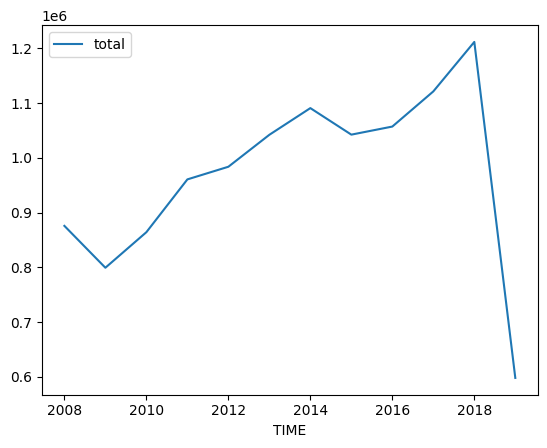

In [ ]:
# Get the mean tourism income per year rather than by country. Do you see any
# evidence of less tourism income during the time of the Great Recession, which
# started in 2008
t = (
    df.loc[df["SUBJECT"] == "INT_REC"]
    .groupby(by=["TIME"])
    .agg(total=("Value", "sum"))
    .sort_values(by=["TIME"], ascending=False)
    # .plot(y="total", use_index=True)
)


In [1]:
import polars as pl
df = pl.read_csv("data/oecd_tourism.csv", 
                 columns=["LOCATION", "SUBJECT", "TIME", "Value"])

In [4]:
# Find the five countries that received the greatest amount of tourist dollars, 
# on average, across years in the data set
(
    df.filter(pl.col("SUBJECT") == "INT_REC")
    .group_by(pl.col("LOCATION"))
    .agg(pl.col("Value").sum().alias("total"))
    .sort(pl.col("total"), descending=True)[:5]
)

LOCATION,total
str,f64
"""USA""",2.419362e6
"""ESP""",766213.991
"""FRA""",715696.693
"""DEU""",587494.277
"""GBR""",569273.0


In [91]:
# Find the five countries whose citizens spent the least amount of tourist 
# dollars, on average, across years in the data set.

(
    df.filter(pl.col("SUBJECT") == "INT-EXP")
    .group_by(pl.col("LOCATION"))
    .agg(pl.col("Value").sum().alias("total"))
    .sort(pl.col("total"))[:5]
)

LOCATION,total
str,f64
"""MLT""",4653.62
"""LVA""",10115.0
"""CRI""",10404.9
"""LTU""",10709.4
"""ISL""",11801.016


In [5]:
# Load oecd_locations.csv into a data frame, using 
# the abbreviated data as an index
df_ = pl.read_csv("data/oecd_locations.csv", new_columns=["LOCATION", "COUNTRY"])

In [7]:
# Join these two data frames together into a new one. In the new data frame,
# there is no LOCATION column. Instead, there is a name column with the full
# name of the country
df_f = (df
        .join(df_, on="LOCATION")
        .drop_nulls()
        .drop("LOCATION")
        .rename({"COUNTRY":"name"})
    )

In [13]:
# Rerun the queries from steps 2 and 3, finding the five countries that spent 
# and received the most, on average, from tourism. But this time, get the 
# name of each country, rather than its abbreviation, for your reports
print(
    df_f.filter(pl.col("SUBJECT") == "INT_REC")
    .group_by(pl.col("name"))
    .agg(pl.col("Value").sum().alias("total"))
    .sort(pl.col("total"), descending=True)[:5]
)
print(
    df_f.filter(pl.col("SUBJECT") == "INT-EXP")
    .group_by(pl.col("name"))
    .agg(pl.col("Value").sum().alias("total"))
    .sort(pl.col("total"))[:5]
)

shape: (5, 2)
┌────────────────┬────────────┐
│ name           ┆ total      │
│ ---            ┆ ---        │
│ str            ┆ f64        │
╞════════════════╪════════════╡
│ United States  ┆ 2.419362e6 │
│ France         ┆ 715696.693 │
│ Germany        ┆ 587494.277 │
│ United Kingdom ┆ 569273.0   │
│ Italy          ┆ 494232.327 │
└────────────────┴────────────┘
shape: (5, 2)
┌─────────┬────────────┐
│ name    ┆ total      │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ Hungary ┆ 32102.292  │
│ Finland ┆ 64647.89   │
│ Israel  ┆ 80718.298  │
│ Denmark ┆ 124587.866 │
│ Austria ┆ 131280.2   │
└─────────┴────────────┘


In [30]:
# Get the mean tourism income per year rather than by country. Do you see any
# evidence of less tourism income during the time of the Great Recession, which
# started in 2008

(
    df.filter(pl.col("SUBJECT") == "INT_REC")
    .group_by(pl.col("TIME"))
    .agg(pl.col("Value").sum().alias("total"))
    .sort(pl.col("TIME"), descending=True)
)

TIME,total
i64,f64
2019,598154.375
2018,1.2116e6
2017,1.1212e6
2016,1.0570e6
2015,1.0423e6
…,…
2012,983670.092
2011,960592.163
2010,864212.682
